In [1]:
# import modules
%pylab inline
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [6]:
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, '/home/anurag/ML/identify_the_digit_analytics_vidya')

# check for existence
os.path.exists(root_dir), os.path.exists(data_dir)

(True, True)

In [9]:
# load dataset
train = pd.read_csv(os.path.join(data_dir, 'Train/train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'Test.txt'))

sample_submission = pd.read_csv(os.path.join(data_dir, 'Sample_Submission.txt'))

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


/home/anurag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


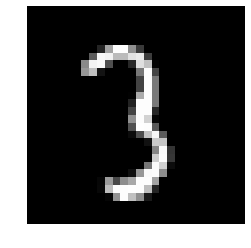

In [10]:
# print an image
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)

img = imread(filepath, flatten=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [11]:
# load images to create train and test set
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)

train_x = np.stack(temp)

train_x /= 255.0
train_x = train_x.reshape(-1, 784).astype('float32')

temp = []
for img_name in test.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
test_x = np.stack(temp)

test_x /= 255.0
test_x = test_x.reshape(-1, 784).astype('float32')

train_y = train.label.values

/home/anurag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/home/anurag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [12]:
# create validation set
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_y[:split_size], train_y[split_size:]


In [14]:
import torch
from torch.autograd import Variable


In [15]:
# number of neurons in each layer
input_num_units = 28*28
hidden_num_units = 500
output_num_units = 10

# set remaining variables
epochs = 5
batch_size = 128
learning_rate = 0.001

In [16]:
# define model
model = torch.nn.Sequential(
  torch.nn.Linear(input_num_units, hidden_num_units),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden_num_units, output_num_units),
)
loss_fn = torch.nn.CrossEntropyLoss()

# define optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
## helper functions
# preprocess a batch of dataset
def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    return temp_batch

# create a batch
def batch_creator(batch_size):
    dataset_name = 'train'
    dataset_length = train_x.shape[0]
    
    batch_mask = rng.choice(dataset_length, batch_size)
    batch_x = eval(dataset_name + '_x')[batch_mask]
    batch_x = preproc(batch_x)
    
    if dataset_name == 'train':
        batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
    
    return batch_x, batch_y

In [22]:
# train network
total_batch = int(train.shape[0]/batch_size)

for epoch in range(epochs):
    avg_cost = 0
    for i in range(total_batch):
        # create batch
        batch_x, batch_y = batch_creator(batch_size)

        # pass that batch for training
        x, y = Variable(torch.from_numpy(batch_x)), Variable(torch.from_numpy(batch_y), requires_grad=False)
        pred = model(x)

        # get loss
        loss = loss_fn(pred, y)

        # perform backpropagation
        loss.backward()
        optimizer.step()
        avg_cost += loss.data[0]/total_batch
        
    print(epoch, avg_cost)


IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

In [23]:
# get training accuracy
x, y = Variable(torch.from_numpy(preproc(train_x))), Variable(torch.from_numpy(train_y), requires_grad=False)
pred = model(x)

final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(train_y, final_pred)

0.8197084548104956

In [24]:
# get validation accuracy
x, y = Variable(torch.from_numpy(preproc(val_x))), Variable(torch.from_numpy(val_y), requires_grad=False)
pred = model(x)
final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(val_y, final_pred)

0.8134013605442176